# Probabilistic Forecasting: Quantile Regression



Quantile regression is a technique for estimating the conditional quantiles of a response variable. By combining the predictions of two quantile regressors, an interval can be constructed, where each model estimates one of the interval’s boundaries. For example, models trained for \( Q = 0.1 \) and \( Q = 0.9 \) produce an 80% prediction interval (\( 90\% - 10\% = 80\% \)).

If a machine learning algorithm capable of modeling quantiles is used as the `regressor` in a [ForecasterDirect](../api/forecasterdirect.html) or [ForecasterDirectMultiVariate](../api/forecasterdirectmultivariate.html), the `predict` method will return predictions for a specified quantile. By creating two forecasters, each configured with a different quantile, their predictions can be combined to generate a prediction interval.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<p>For more examples on how to use probabilistic forecasting, check out the following articles:</p>
<ul>
    <li>
        <a href="https://cienciadedatos.net/documentos/py42-probabilistic-forecasting" target="_blank">
            Probabilistic forecasting with machine learning
        </a>
    </li>
    <li>
        <a href="https://cienciadedatos.net/documentos/py60-probabilistic-forecasting-prediction-intervals-multi-step-forecasting" target="_blank">
            Probabilistic forecasting: prediction intervals for multi-step time series forecasting
        </a>
    </li>
    <li>
        <a href="../faq/probabilistic-forecasting-crps-score.html" target="_blank">
            Continuous Ranked Probability Score (CRPS) in probabilistic forecasting
        </a>
    </li>
</ul>


</div>

As opposed to linear regression, which is intended to estimate the conditional mean of the response variable given certain values of the predictor variables, quantile regression aims at estimating the conditional quantiles of the response variable. For a continuous distribution function, the $\alpha$-quantile $Q_{\alpha}(x)$ is defined such that the probability of $Y$ being smaller than $Q_{\alpha}(x)$ is, for a given $X=x$, equal to $\alpha$. For example, 36% of the population values are lower than the quantile  $Q=0.36$. The most known quantile is the 50%-quantile, more commonly called the median.

By combining the predictions of two quantile regressors, it is possible to build an interval. Each model estimates one of the limits of the interval. For example, the models obtained for $Q = 0.1$ and $Q = 0.9$ produce an 80% prediction interval (90% - 10% = 80%).

Several machine learning algorithms are capable of modeling quantiles. Some of them are:

+ [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html)

+ [XGBoost](https://xgboost.readthedocs.io/en/stable/python/index.html)

+ [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor)

+ [Scikit-learn HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html)

+ [Scikit-learn QuantileRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html#sklearn.linear_model.QuantileRegressor)

+ [skranger quantile RandomForest](https://skranger.readthedocs.io/en/stable/index.html)


Just as the squared-error loss function is used to train models that predict the mean value, a specific loss function is needed in order to train models that predict quantiles. The most common metric used for quantile regression is calles [quantile loss  or pinball loss](https://en.wikipedia.org/wiki/Quantile_regression):


$$\text{pinball}(y, \hat{y}) = \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}}-1}  \alpha \max(y_i - \hat{y}_i, 0) + (1 - \alpha) \max(\hat{y}_i - y_i, 0)$$

where $\alpha$ is the target quantile, $y$ the real value and $\hat{y}$ the quantile prediction.

It can be seen that loss differs depending on the evaluated quantile. The higher the quantile, the more the loss function penalizes underestimates, and the less it penalizes overestimates. As with MSE and MAE, the goal is to minimize its values (the lower loss, the better).

Two disadvantages of quantile regression, compared to the bootstrap approach to prediction intervals, are that each quantile needs its regressor and quantile regression is not available for all types of regression models. However, once the models are trained, the inference is much faster since no iterative process is needed.

This type of prediction intervals can be easily estimated using [ForecasterDirect](../api/forecasterdirect.html) and [ForecasterDirectMultiVariate](../api/forecasterdirectmultivariate.html) models.

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

Forecasters of type <code>ForecasterDirect</code> are slower than <code>ForecasterRecursive</code> because they require training one model per step. Although they can achieve better performance, their scalability is an important limitation when many steps need to be predicted. To limit the time required to run the following examples, the data is aggregated from hourly frequency to daily frequency and only 7 steps ahead (one week) are predicted.

</div>

In [ ]:
# Data download
# ==============================================================================
data = fetch_dataset(name='vic_electricity')

vic_electricity
---------------
Half-hourly electricity demand for Victoria, Australia
O'Hara-Wild M, Hyndman R, Wang E, Godahewa R (2022).tsibbledata: Diverse
Datasets for 'tsibble'. https://tsibbledata.tidyverts.org/,
https://github.com/tidyverts/tsibbledata/.
https://tsibbledata.tidyverts.org/reference/vic_elec.html
Shape of the dataset: (52608, 4)


In [ ]:
# Data preparation (aggregation at daily level)
# ==============================================================================
data = data.resample(rule="D", closed="left", label="right").agg(
    {"Demand": "sum", "Temperature": "mean", "Holiday": "max"}
)
data.head(3)

,Demand,Temperature,Holiday
Time,,,
2012-01-01,82531.745918,21.047727,True
2012-01-02,227778.257304,26.578125,True
2012-01-03,275490.988882,31.751042,True


In [ ]:
# Split data into train-validation-test
# ==============================================================================
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
end_train = '2013-12-31 23:59:00'
end_validation = '2014-9-30 23:59:00'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(
    f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}"
    f"  (n={len(data_train)})"
)
print(
    f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}"
    f"  (n={len(data_val)})"
)
print(
    f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}"
    f"  (n={len(data_test)})"
)

Train dates      : 2012-01-01 00:00:00 --- 2013-12-31 00:00:00  (n=731)
Validation dates : 2014-01-01 00:00:00 --- 2014-09-30 00:00:00  (n=273)
Test dates       : 2014-10-01 00:00:00 --- 2014-12-30 00:00:00  (n=91)


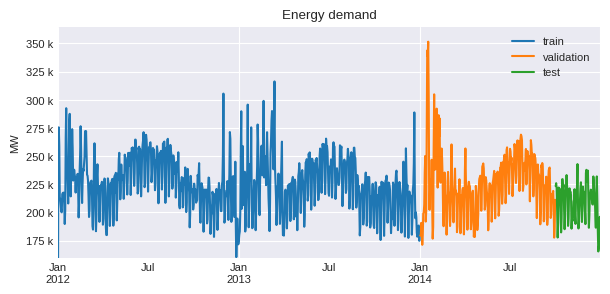

In [ ]:
# Plot time series partition
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Demand'].plot(label='train', ax=ax)
data_val['Demand'].plot(label='validation', ax=ax)
data_test['Demand'].plot(label='test', ax=ax)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylim(bottom=160_000)
ax.set_ylabel('MW')
ax.set_xlabel('')
ax.set_title('Energy demand')
ax.legend();

### Quantile regresion models

An 80% prediction interval is estimated for 7 steps-ahead predictions using quantile regression. A LightGBM gradient boosting model is trained in this example, however, the reader may use any other model just replacing the definition of the regressor.

In [ ]:
# Create forecasters: one for each bound of the interval
# ==============================================================================
# The forecasters obtained for alpha=0.1 and alpha=0.9 produce a 80% confidence
# interval (90% - 10% = 80%).

# Forecaster for quantile 10%
forecaster_q10 = ForecasterDirect(
                     regressor = LGBMRegressor(
                                     objective     = 'quantile',
                                     metric        = 'quantile',
                                     alpha         = 0.1,
                                     learning_rate = 0.01,
                                     max_depth     = 3,
                                     n_estimators  = 500,
                                     verbose       = -1
                                 ),
                     lags = 7,
                     steps = 7
                 )
                  
# Forecaster for quantile 90%
forecaster_q90 = ForecasterDirect(
                     regressor = LGBMRegressor(
                                     objective     = 'quantile',
                                     metric        = 'quantile',
                                     alpha         = 0.9,
                                     learning_rate = 0.1,
                                     max_depth     = 3,
                                     n_estimators  = 100,
                                     verbose       = -1
                                 ),
                     lags = 7,
                     steps = 7
                 )

forecaster_q10.fit(y=data['Demand'])
forecaster_q90.fit(y=data['Demand'])

When validating a quantile regression model, a custom metric must be provided depending on the quantile being estimated.

In [ ]:
# Loss function for each quantile (pinball_loss)
# ==============================================================================
def mean_pinball_loss_q10(y_true, y_pred):
    """
    Pinball loss for quantile 10.
    """
    return mean_pinball_loss(y_true, y_pred, alpha=0.1)


def mean_pinball_loss_q90(y_true, y_pred):
    """
    Pinball loss for quantile 90.
    """
    return mean_pinball_loss(y_true, y_pred, alpha=0.9)

### Predictions (backtesting)

Once the quantile forecasters are trained, they can be used to predict each of the bounds of the forecasting interval.

In [ ]:
# Backtesting on test data
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 7, 
         initial_train_size = len(data.loc[:end_validation]),
         refit              = False
     )

metric_q10, predictions_q10 = backtesting_forecaster(
                                  forecaster    = forecaster_q10,
                                  y             = data['Demand'],
                                  cv            = cv,
                                  metric        = mean_pinball_loss_q10,
                                  n_jobs        = 'auto',
                                  verbose       = False,
                                  show_progress = True
                              )

metric_q90, predictions_q90 = backtesting_forecaster(
                                  forecaster    = forecaster_q90,
                                  y             = data['Demand'],
                                  cv            = cv,
                                  metric        = mean_pinball_loss_q90,
                                  n_jobs        = 'auto',
                                  verbose       = False,
                                  show_progress = True
                              )

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

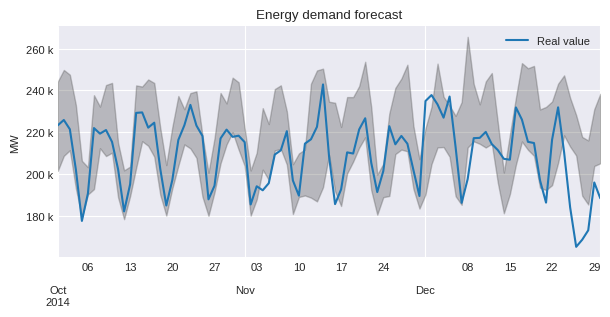

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[end_validation:, 'Demand'].plot(ax=ax, label='Real value')
ax.fill_between(
    data.loc[end_validation:].index,
    predictions_q10['pred'],
    predictions_q90['pred'],
    color = '#444444',
        alpha = 0.3,
)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel('MW')
ax.set_xlabel('')
ax.set_title('Energy demand forecast')
ax.legend();

Predictions generated for each model are used to define the upper and lower limits of the interval.

In [ ]:
# Predicted interval coverage (on test data)
# ==============================================================================
coverage = calculate_coverage(
    y_true      = data.loc[end_validation:, 'Demand'],
    lower_bound = predictions_q10["pred"], 
    upper_bound = predictions_q90["pred"]
)
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions_q90["pred"] - predictions_q10["pred"]).sum()
print(f"Area of the interval: {round(area, 2)}")

Predicted interval coverage: 74.73 %
Area of the interval: 2832564.24
